In [1]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.optimizers import Adam

from transformers import AutoTokenizer
from transformers import DistilBertForTokenClassification
from transformers import Trainer, TrainingArguments

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

# LightGBM, for first run, uncomment to run

In [2]:
train_processed_data_expanded = pd.read_csv('./output/scaled_train_data.csv')
# train_processed_data_expanded = train_processed_data_expanded.drop('Unnamed: 0', axis=1)

train_processed_data_expanded

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,encoded_tags
0,0.428620,1.000000,0.509812,0.000000e+00,8.906781e-07,0.000000,0.000000,0.509813,0.000001,2.486586e-06,...,0.0,9.179891e-05,0.022490,0.680028,1.000000,0.459038,6.565172e-07,8.784210e-09,0.000003,184
1,0.578240,0.999839,0.016088,6.101171e-03,3.595742e-01,0.000223,0.000125,0.016082,0.037998,6.038352e-05,...,1.0,5.081934e-03,0.039148,0.764455,0.000006,0.019570,2.624302e-01,0.000000e+00,0.000404,141
2,0.467841,0.996626,0.002890,0.000000e+00,0.000000e+00,0.000000,0.000000,0.002891,0.000000,4.092086e-04,...,0.0,1.040388e-04,0.028460,0.859879,0.242375,0.361443,3.157241e-02,6.552889e-06,0.000009,194
3,0.322503,0.989857,0.023677,1.015950e-06,7.954423e-01,0.412684,0.127934,0.015942,0.116336,6.150468e-05,...,0.0,2.787286e-04,0.033901,0.751330,0.049434,0.032961,4.568948e-02,1.137700e-03,0.000133,60
4,0.668298,1.000000,1.000000,6.884876e-09,1.000000e+00,0.000000,0.000000,1.000000,0.052762,7.937312e-07,...,0.0,1.587743e-08,0.000004,0.580702,0.000543,1.000000,8.483211e-01,1.026006e-03,0.000000,203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5388330,0.668298,1.000000,1.000000,6.884876e-09,1.000000e+00,0.000000,0.000000,1.000000,0.052762,7.937312e-07,...,0.0,1.587743e-08,0.000004,0.580702,0.000543,1.000000,8.483211e-01,1.026006e-03,0.000000,203
5388331,0.668298,1.000000,1.000000,6.884876e-09,1.000000e+00,0.000000,0.000000,1.000000,0.052762,7.937312e-07,...,0.0,1.587743e-08,0.000004,0.580702,0.000543,1.000000,8.483211e-01,1.026006e-03,0.000000,203
5388332,0.668298,1.000000,1.000000,6.884876e-09,1.000000e+00,0.000000,0.000000,1.000000,0.052762,7.937312e-07,...,0.0,1.587743e-08,0.000004,0.580702,0.000543,1.000000,8.483211e-01,1.026006e-03,0.000000,203
5388333,0.293524,0.951149,0.006017,0.000000e+00,4.639506e-07,0.000000,0.000000,0.006017,0.000001,2.380474e-04,...,0.0,8.850077e-05,0.009008,0.996098,0.070973,0.048470,1.586959e-01,6.269141e-01,0.000092,142


In [3]:
# train_processed_data = pd.read_csv('./output/non_nan_balanced_data.csv')
val_processed_data_expanded = pd.read_csv('./output/scaled_val_data.csv') 
# processed_data_expanded = processed_data_expanded.drop('Unnamed: 0', axis=1)

val_processed_data_expanded

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,encoded_tags
0,0.566236,0.697855,0.009106,0.000000e+00,0.000000e+00,0.000000,0.000000,0.009106,0.000000,3.972780e-05,...,0.0,9.179891e-05,2.248993e-02,0.680028,1.000000,0.459038,6.565172e-07,8.784210e-09,0.000003,184
1,0.395012,0.999643,0.012381,0.000000e+00,9.524506e-04,0.000000,0.000000,0.012382,0.000697,1.076902e-04,...,0.0,4.002599e-05,6.486638e-03,0.730756,0.007162,0.013356,6.395042e-04,0.000000e+00,0.000405,180
2,0.668298,1.000000,1.000000,6.884876e-09,1.000000e+00,0.000000,0.000000,1.000000,0.052762,7.937312e-07,...,0.0,1.587743e-08,3.891505e-06,0.580702,0.000543,1.000000,8.483211e-01,1.026006e-03,0.000000,203
3,0.387087,0.560943,0.115950,3.422385e-09,7.597835e-01,0.928852,0.000010,0.115950,1.000000,3.698501e-06,...,1.0,3.437215e-09,1.528109e-08,0.184108,0.000010,0.197636,1.000000e+00,1.319294e-05,0.000027,154
4,0.481720,0.478761,0.001350,4.569686e-06,1.391312e-02,0.000000,0.000000,0.001350,0.003393,5.133540e-05,...,1.0,1.723015e-06,3.776245e-05,0.094714,0.017997,0.015916,2.773921e-01,0.000000e+00,0.000272,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123244,0.668298,1.000000,1.000000,6.884876e-09,1.000000e+00,0.000000,0.000000,1.000000,0.052762,7.937312e-07,...,0.0,1.587743e-08,3.891505e-06,0.580702,0.000543,1.000000,8.483211e-01,1.026006e-03,0.000000,203
1123245,0.668298,1.000000,1.000000,6.884876e-09,1.000000e+00,0.000000,0.000000,1.000000,0.052762,7.937312e-07,...,0.0,1.587743e-08,3.891505e-06,0.580702,0.000543,1.000000,8.483211e-01,1.026006e-03,0.000000,203
1123246,0.428620,1.000000,0.509812,0.000000e+00,8.906781e-07,0.000000,0.000000,0.509813,0.000001,2.486586e-06,...,0.0,9.179891e-05,2.248993e-02,0.680028,1.000000,0.459038,6.565172e-07,8.784210e-09,0.000003,184
1123247,0.288678,0.987561,0.033791,2.722036e-03,1.401579e-02,0.000009,0.000208,0.033779,0.001292,4.493264e-05,...,1.0,8.863601e-04,2.160720e-02,0.905640,0.000995,0.066771,1.111779e-01,2.173034e-02,0.000083,75


In [4]:
X_val = val_processed_data_expanded.drop('encoded_tags', axis=1)
y_val = val_processed_data_expanded['encoded_tags']

X_val

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
0,0.566236,0.697855,0.009106,0.000000e+00,0.000000e+00,0.000000,0.000000,0.009106,0.000000,3.972780e-05,0.171641,0.0,9.179891e-05,2.248993e-02,0.680028,1.000000,0.459038,6.565172e-07,8.784210e-09,0.000003
1,0.395012,0.999643,0.012381,0.000000e+00,9.524506e-04,0.000000,0.000000,0.012382,0.000697,1.076902e-04,0.632633,0.0,4.002599e-05,6.486638e-03,0.730756,0.007162,0.013356,6.395042e-04,0.000000e+00,0.000405
2,0.668298,1.000000,1.000000,6.884876e-09,1.000000e+00,0.000000,0.000000,1.000000,0.052762,7.937312e-07,0.376586,0.0,1.587743e-08,3.891505e-06,0.580702,0.000543,1.000000,8.483211e-01,1.026006e-03,0.000000
3,0.387087,0.560943,0.115950,3.422385e-09,7.597835e-01,0.928852,0.000010,0.115950,1.000000,3.698501e-06,0.203465,1.0,3.437215e-09,1.528109e-08,0.184108,0.000010,0.197636,1.000000e+00,1.319294e-05,0.000027
4,0.481720,0.478761,0.001350,4.569686e-06,1.391312e-02,0.000000,0.000000,0.001350,0.003393,5.133540e-05,0.032889,1.0,1.723015e-06,3.776245e-05,0.094714,0.017997,0.015916,2.773921e-01,0.000000e+00,0.000272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123244,0.668298,1.000000,1.000000,6.884876e-09,1.000000e+00,0.000000,0.000000,1.000000,0.052762,7.937312e-07,0.376586,0.0,1.587743e-08,3.891505e-06,0.580702,0.000543,1.000000,8.483211e-01,1.026006e-03,0.000000
1123245,0.668298,1.000000,1.000000,6.884876e-09,1.000000e+00,0.000000,0.000000,1.000000,0.052762,7.937312e-07,0.376586,0.0,1.587743e-08,3.891505e-06,0.580702,0.000543,1.000000,8.483211e-01,1.026006e-03,0.000000
1123246,0.428620,1.000000,0.509812,0.000000e+00,8.906781e-07,0.000000,0.000000,0.509813,0.000001,2.486586e-06,0.601457,0.0,9.179891e-05,2.248993e-02,0.680028,1.000000,0.459038,6.565172e-07,8.784210e-09,0.000003
1123247,0.288678,0.987561,0.033791,2.722036e-03,1.401579e-02,0.000009,0.000208,0.033779,0.001292,4.493264e-05,0.720373,1.0,8.863601e-04,2.160720e-02,0.905640,0.000995,0.066771,1.111779e-01,2.173034e-02,0.000083


In [5]:
# Remove the Tag class with below 10 count, double check to make sure
counts = y_val.value_counts()

y_val = y_val[y_val.isin(counts[counts > 10].index)] # 10 is cutof as mentioned in Preprocessing step
X_val = X_val.loc[y_val.index]

In [6]:
test_processed_data_expanded = pd.read_csv('./output/scaled_test_data.csv')
# train_processed_data_expanded = train_processed_data_expanded.drop('Unnamed: 0', axis=1)

test_processed_data_expanded

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,encoded_tags
0,0.327324,0.999999,0.219593,1.000000e+00,4.189355e-01,0.000000,0.00000,0.219594,5.066213e-02,6.685087e-06,...,0.0,1.000000e+00,1.000000,0.998936,0.001565,0.153770,5.788697e-01,8.198362e-01,0.000041,124
1,0.327324,0.999999,0.219593,1.000000e+00,4.189355e-01,0.000000,0.00000,0.219594,5.066213e-02,6.685087e-06,...,0.0,1.000000e+00,1.000000,0.998936,0.001565,0.153770,5.788697e-01,8.198362e-01,0.000041,124
2,0.268661,0.999726,0.011852,0.000000e+00,4.806285e-08,0.000000,0.00000,0.011853,1.266585e-07,1.335921e-04,...,0.0,1.040388e-04,0.028460,0.859879,0.242375,0.361443,3.157241e-02,6.552889e-06,0.000009,194
3,0.428620,1.000000,0.509812,0.000000e+00,8.906781e-07,0.000000,0.00000,0.509813,1.013268e-06,2.486586e-06,...,0.0,9.179891e-05,0.022490,0.680028,1.000000,0.459038,6.565172e-07,8.784210e-09,0.000003,184
4,0.387329,0.612336,0.001213,0.000000e+00,0.000000e+00,0.000000,0.00000,0.001214,0.000000e+00,4.416578e-04,...,0.0,1.099598e-05,0.008395,0.300106,0.000536,0.002547,0.000000e+00,4.597327e-07,0.002466,214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149097,0.296351,0.983435,0.160314,4.718805e-03,4.475495e-02,0.000000,0.00000,0.160314,1.199722e-03,9.322364e-06,...,1.0,4.734385e-03,0.001017,0.706279,0.000131,0.130509,3.088446e-02,4.192803e-07,0.000040,106
1149098,0.668298,1.000000,1.000000,6.884876e-09,1.000000e+00,0.000000,0.00000,1.000000,5.276211e-02,7.937312e-07,...,0.0,1.587743e-08,0.000004,0.580702,0.000543,1.000000,8.483211e-01,1.026006e-03,0.000000,203
1149099,0.387087,0.560943,0.115950,3.422385e-09,7.597835e-01,0.928852,0.00001,0.115950,1.000000e+00,3.698501e-06,...,1.0,2.448698e-08,0.000063,0.208585,0.000009,0.176432,8.838643e-01,1.165525e-05,0.000031,99
1149100,0.428620,1.000000,0.509812,0.000000e+00,8.906781e-07,0.000000,0.00000,0.509813,1.013268e-06,2.486586e-06,...,0.0,9.179891e-05,0.022490,0.680028,1.000000,0.459038,6.565172e-07,8.784210e-09,0.000003,184


In [7]:
# Define the features and the target
# scale_pos_weight = len(processed_data_expanded[processed_data_expanded['encoded_label'] == 1]) / len(processed_data_expanded[processed_data_expanded['encoded_label'] == 0])
X_train = train_processed_data_expanded.drop('encoded_tags', axis=1)
y_train = train_processed_data_expanded['encoded_tags']

X_test = test_processed_data_expanded.drop('encoded_tags', axis=1)
y_test = test_processed_data_expanded['encoded_tags']

In [8]:
# # Calculate the scale_pos_weight if you haven't done it yet
# scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
# scale_pos_weight 

import lightgbm as lgb

# Compute class weights
class_weights = y_train.value_counts().min() / y_train.value_counts()

# Convert to the dataset
dtrain = lgb.Dataset(X_train, label=y_train, weight=y_train.map(class_weights))
dtest = lgb.Dataset(X_test, label=y_test, weight=y_test.map(class_weights))

In [26]:
# # Create the model
# # Calculate weights
# weights = np.where(y_train == 0, 69, 0.1)

# # lgbm = lgb.LGBMClassifier( is_unbalance=True) # 0.99 scale_pos_weight scale_pos_weight=9
# lgbm = lgb.LGBMClassifier(objective='binary',
#                           scale_pos_weight=scale_pos_weight, # 69
# #                           is_unbalance=True,
# #                           max_depth=6,
#                           min_child_weight=1,
#                           subsample=0.8,
#                           colsample_bytree=0.8,
#                           learning_rate=0.01,
#                           n_estimators=1000)

# # Fit the model
# lgbm.fit(X_train, y_train)#, sample_weight=weights)

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01, min_child_weight=1,
               n_estimators=1000, objective='binary',
               scale_pos_weight=0.03212176665027204, subsample=0.8)

In [ ]:
# lgbm.booster_.save_model('./temp/lgbm_model.txt') # lgbm_model_69 lgbm_model_019 lgbm_mode

In [ ]:
# train_processed_data_expanded.to_csv("./temp/scaled_train_one_col.csv")

# Training

In [10]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss


# Create a LightGBM dataset
data = dtrain

# Define parameters of the already trained model
params = {
    'boosting_type': 'gbdt',             # memory issue
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train)),
#     'scale_pos_weight': scale_pos_weight, 
#     'min_child_weight': 5,
    'subsample': 0.8,                    # memory issue
    'colsample_bytree': 0.8,
    'learning_rate': 0.05,
#     'n_estimators': 1000,                 # memory issue
#     'max_bin': 63,                       # reduced for less memory usage
#     'num_leaves': 31,                    # memory issue
    'device': 'gpu'
}


print("----------------------------------------------------------")

# Training the model --> 3 round takes 10min
# num_boost_round = len(cv_results['multi_error-mean'])
bst = lgb.train(params, data, num_boost_round=3) 

----------------------------------------------------------
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3332
[LightGBM] [Info] Number of data points in the train set: 5388335, number of used features: 20
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 17 dense feature groups (102.77 MB) transferred to GPU in 0.110183 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Sta

[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start training from score -5.402677
[LightGBM] [Info] Start trai

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

# get the class with the highest probability for each instance
# Predict the class probabilities on the test set
# 3: match with XGBoost, 95 precision, 91 recall, 95 ROC AUC --> as good as XGBoost 5r
y_pred_prob = bst.predict(X_test)
y_pred_max_prob = np.argmax(y_pred_prob, axis=1)

y_pred_max_prob

array([124, 124, 194, ...,  99, 184, 184], dtype=int64)

In [13]:
# Print classification report
print(classification_report(y_test, y_pred_max_prob))

E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3486
           1       1.00      1.00      1.00      4293
           2       1.00      1.00      1.00      2190
           3       1.00      0.50      0.67         2
           4       1.00      1.00      1.00       281
           5       1.00      1.00      1.00      1265
           6       1.00      0.99      1.00       381
           7       1.00      1.00      1.00      4526
           8       1.00      1.00      1.00        19
           9       1.00      0.90      0.95      3493
          10       1.00      1.00      1.00        31
          11       1.00      1.00      1.00      2601
          12       1.00      1.00      1.00        94
          13       1.00      1.00      1.00        26
          14       1.00      0.99      0.99      4877
          15       1.00      1.00      1.00       743
          16       1.00      1.00      1.00       348
          17       0.99    

E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, roc_curve

# Binarize the output
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_test_pred_bin = lb.transform(y_pred_max_prob)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test_bin, y_test_pred_bin, average='macro')
print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.95701893477956


In [11]:
bst.save_model('./output/lgbm_model_005_lr_3r.txt')

# Validation data

Please make sure to save model above, we need to load it below

In [15]:
lgbm = lgb.Booster(model_file='./output/lgbm_model_005_lr_3r.txt')# lgbm_model_005_lr_3r

In [16]:
# Get feature importance
importance = lgbm.feature_importance()

# Get feature names
feature_name = lgbm.feature_name()

# Create a data frame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_name,
    'Importance': importance
})

importance_df = importance_df.sort_values('Importance', ascending = False)

print(importance_df)

       Feature  Importance
16  feature_16        2048
14  feature_14        1896
7    feature_7        1602
19  feature_19        1565
0    feature_0        1330
1    feature_1        1325
12  feature_12        1270
9    feature_9        1149
2    feature_2        1066
13  feature_13        1054
10  feature_10        1011
15  feature_15        1001
6    feature_6         836
4    feature_4         652
3    feature_3         570
17  feature_17         557
8    feature_8         463
5    feature_5         256
18  feature_18         214
11  feature_11         115


f16: NumWithdrawalsPerMonth --> tag cluster

f14: StdDevBalance --> tag cluster

f7: num_deposits_sum --> address

f19 : MeanSentETHPerLifetime --> tag cluster

f0: block_timestamp_min --> address

f1: block_timestamp_max --> address

f12: MeanNumTransactions --> tag cluster

f9: mean_time_between_transactions --> address

The distribution of importance is more address/cluster balance, XGBoost based heavily on tag_cluster related features

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

# Predict and evaluate the model
y_test_pred = lgbm.predict(X_val) # X_val X_test
y_test_pred

array([[1.21686223e-05, 1.21686038e-05, 1.21687062e-05, ...,
        1.21676996e-05, 1.14017618e-05, 1.21663961e-05],
       [1.23054865e-05, 1.23465295e-05, 1.23465834e-05, ...,
        1.23463807e-05, 1.23465645e-05, 1.23463543e-05],
       [1.93901511e-05, 1.23036337e-05, 1.23033709e-05, ...,
        1.23044870e-05, 1.17257986e-05, 1.23020738e-05],
       ...,
       [1.23235956e-05, 1.23235769e-05, 1.23236806e-05, ...,
        1.23236635e-05, 1.17436782e-05, 1.23195015e-05],
       [1.23459085e-05, 1.23459860e-05, 1.23455340e-05, ...,
        1.23459754e-05, 1.23458368e-05, 1.23458630e-05],
       [1.93901511e-05, 1.23036337e-05, 1.23033709e-05, ...,
        1.23044870e-05, 1.17257986e-05, 1.23020738e-05]])

In [18]:
## Do this if load model from txt file
y_pred_class = np.argmax(y_test_pred, axis=1) #(y_test_pred > 0.5).astype(int)

y_pred_class

array([184, 180, 203, ..., 184,  75, 203], dtype=int64)

In [19]:
print (classification_report(y_val, y_pred_class))
# Note: 3 round: 95 precision, 89 recall, 96 ROC AUC --> On par with XGBoost 5r

E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3407
           1       1.00      1.00      1.00      4197
           2       1.00      1.00      1.00      2141
           4       1.00      1.00      1.00       275
           5       1.00      1.00      1.00      1237
           6       1.00      0.98      0.99       372
           7       1.00      1.00      1.00      4424
           8       1.00      1.00      1.00        18
           9       1.00      0.89      0.94      3414
          10       1.00      1.00      1.00        30
          11       1.00      1.00      1.00      2543
          12       1.00      1.00      1.00        92
          13       1.00      1.00      1.00        26
          14       1.00      0.99      0.99      4768
          15       1.00      1.00      1.00       727
          16       1.00      1.00      1.00       340
          17       0.99      1.00      0.99       278
          18       1.00    

E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, roc_curve

# Binarize the output
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_val)
y_test_pred_bin = lb.transform(y_pred_class)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test_bin, y_test_pred_bin, average='macro')
print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.958897142472568


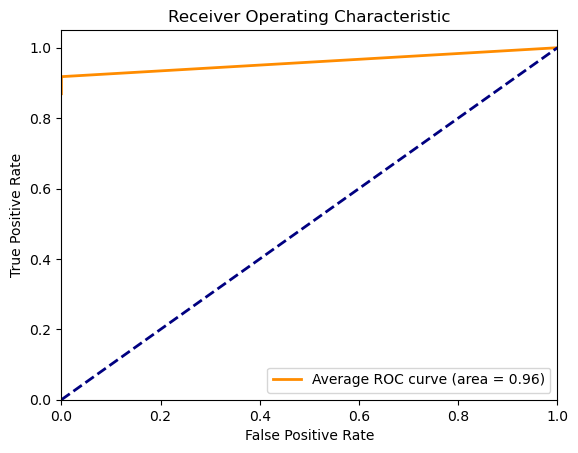

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve

# # Compute ROC curve and ROC area
# fpr, tpr, _ = roc_curve(y_test, y_pred_class)
# roc_auc = auc(fpr, tpr)

# # Plot
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # random classifier
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")


# plt.savefig('./output/lightGBM.png')
# plt.show()

# Compute ROC curve and ROC area for each class
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot average ROC curve
plt.figure()
plt.plot(fpr["macro"], tpr["macro"], color='darkorange', lw=2, label='Average ROC curve (area = %0.2f)' % roc_auc["macro"])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.savefig('./output/lightGB_3r.png')
plt.show()

In [ ]:
# from sklearn.metrics import average_precision_score

# # LightGBM
# lgb_auprc = average_precision_score(y_test, y_pred_class)
# print(f'LightGBM AUPRC: {lgb_auprc}')